# Imports

In [1]:
import scanpy as sc

import pandas as pd
import numpy as np

import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import scipy
from scipy.stats import spearmanr
from scipy.stats import zscore
from scipy.stats import pearsonr
from sklearn.metrics import pairwise_distances

# utils function -- helper functions for plotting
import sys
sys.path.append('../../utils/')
import figure_utils as figure_utils

In [2]:
# create figures directory
import os

directory_path = 'figures'
if not os.path.exists(directory_path):
    # If not, create the directory
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' created successfully.")
else:
    print(f"Directory '{directory_path}' already exists.")

Directory 'figures' already exists.


# Plot aesthetics

In [3]:
matplotlib.rcParams['figure.dpi'] = 500 # 150 dpi resolution
matplotlib.rcParams['image.cmap'] = 'Spectral_r' # preferred color map
# matplotlib.rcParams['figure.figsize'] = [6, 6] # Square
# no bounding boxes or axis:
matplotlib.rcParams['axes.spines.bottom'] = "off"
matplotlib.rcParams['axes.spines.top'] = "off"
matplotlib.rcParams['axes.spines.left'] = "off"
matplotlib.rcParams['axes.spines.right'] = "off"

%matplotlib inline

In [4]:
# UMAP PARAMS
DOT_SIZE = 25
LEGEND_FONTSIZE = 8
LEGEND_FONTOUTLINE = 1
UMAP_FIGSIZE = (10,10)

# SEXES COLOR -- NEW
HERM_COLOR = '#ff8b00'
MALE_COLOR = '#2258a5'
SHARED_SEX_COLOR = '#349c55'

# AXIS TICK COLORS
AXIS_TICK_COLORS = 'black'

#  Sheath Socket Colors
SHEATH_COLOR = '#3ac9c9' 
SOCKET_COLOR = '#c47841'

# COMPARTMENTS COLOR -- Non-neural, Coelomocyte, Glia, Neuron
COMPARTMENTS_COLOR = ['#c63287','#ff99da','#693996','#fdcd0f']

In [5]:
# load data
ad_url = "https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/worm-glia-atlas/WholeData.h5ad" 
ad_glia_url = "https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/worm-glia-atlas/GliaOnly.h5ad" 

adata = sc.read('../../data/WholeData.h5ad', backup_url=ad_url)
adata_glia = sc.read('../../data/GliaOnly.h5ad', backup_url=ad_glia_url)

# Figure 5A -- Hierarchical Clustering of Glia

In [6]:
# we perform hierarchical clustering at the PC level -- dimension of PC space for our analysis was 50
linkage, labels, paired_distances = figure_utils.compute_linkage(
    data_obsm=adata_glia.obsm['X_pca_harmony'],
    data_obs_index=adata_glia.obs_names,
    data_obs_label=adata_glia.obs['Cluster_Celltype'],
    feature_names=[f'PC{idx}' for idx in range(1,51)]
)

# ploting aesthetics related/color: color for the sex specificity + color for sheath/socket
# map the index (which are the Cluster_Celltype) to their sex specific labels from the anndata
sex_spec_map = dict(zip(
    adata_glia.obs['Cluster_Celltype'],
    adata_glia.obs['cluster_sex_label'].str.split('_').str.get(1)
))

# map the index to their specific glia types from the anndata
glia_map = dict(zip(
    adata_glia.obs['Cluster_Celltype'],
    adata_glia.obs['SheathSocket_label']
))

# assign the colors to sexes
color_sex = paired_distances.columns.map(sex_spec_map).map({
    'Both':SHARED_SEX_COLOR,
    'Male':MALE_COLOR,
    'Herm':HERM_COLOR 
})

# asssign the colors to sheath and socket 
color_glia = paired_distances.columns.map(glia_map).map({
    'Sheath':SHEATH_COLOR,
    'Socket':SOCKET_COLOR
})

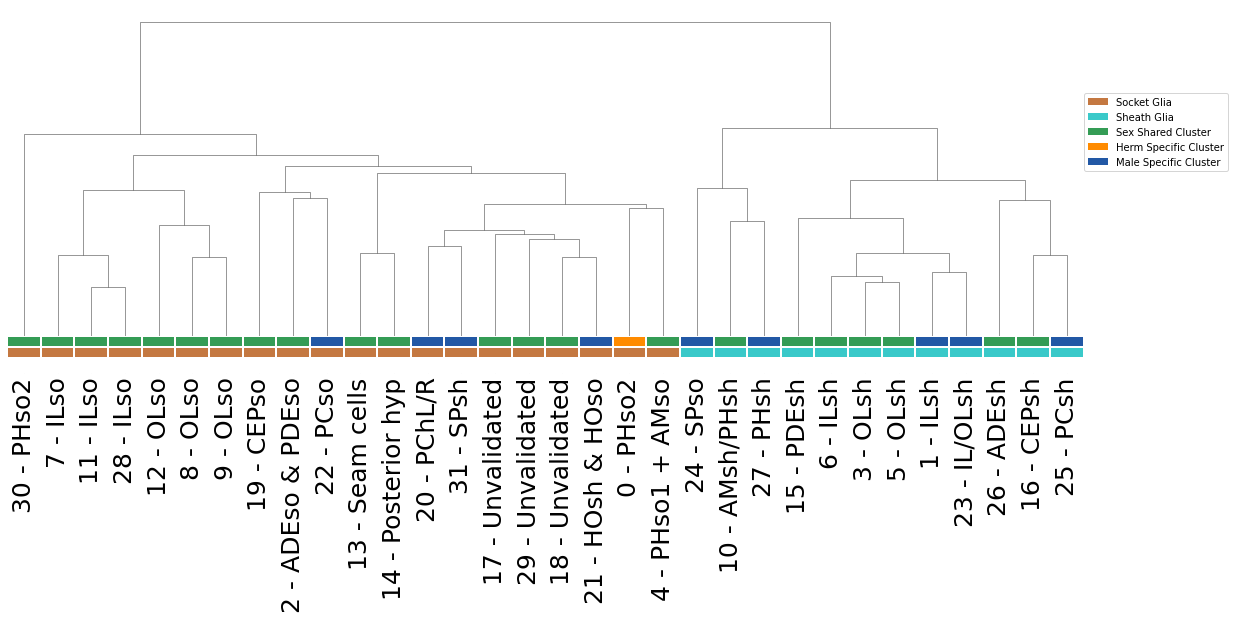

In [7]:
# plot the dendrogram -- plotted using the clustermap
dendrogram = sns.clustermap(
    1 - paired_distances,
    xticklabels=paired_distances.index,
    col_colors=[color_sex,color_glia],
    yticklabels=False,
    figsize=(150,7),  
    linewidth=0.05,
    dendrogram_ratio=(0.9,0.9), # can just be done through illustrator
    cmap='RdBu_r',
    cbar_pos=None,
#     col_linkage=linkage # the computed linkage is also the same default clustering that seaborn does
)

# hide the row dendorgrams on clustermap
dendrogram.ax_row_dendrogram.set_visible(False)

# legends for the dendrogram
dendrogram.ax_col_dendrogram.bar(0,0, color=SOCKET_COLOR, label='Socket Glia', linewidth=0)
dendrogram.ax_col_dendrogram.bar(0,0, color=SHEATH_COLOR, label='Sheath Glia', linewidth=0)
dendrogram.ax_col_dendrogram.bar(0,0, color=SHARED_SEX_COLOR, label='Sex Shared Cluster', linewidth=0)
dendrogram.ax_col_dendrogram.bar(0,0, color=HERM_COLOR, label='Herm Specific Cluster', linewidth=0)
dendrogram.ax_col_dendrogram.bar(0,0, color=MALE_COLOR, label='Male Specific Cluster', linewidth=0)
# dendrogram.ax_col_dendrogram.legend(loc="upper right", ncol=1, title='')
dendrogram.ax_col_dendrogram.legend(loc=(1,0.5), ncol=1, title='')


# hide the labels on the axes
dendrogram.ax_heatmap.set_xlabel('')
dendrogram.ax_heatmap.set_ylabel('')
dendrogram.ax_heatmap.set_yticklabels('')

# tick size fonts
dendrogram.ax_heatmap.set_xticklabels(dendrogram.ax_heatmap.get_xmajorticklabels(), fontsize = 25)
dendrogram.ax_heatmap.axes.tick_params(axis='both', which='both', length=0.01)
dendrogram.savefig('figures/figure_5A_HierarchicalClustering.png')

# hide the y-axis labels
plt.show()

# Figure 5B -- Sheath & Socket Glia UMAP

In [8]:
# reload plot aesthetics

%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 500 # 150 dpi resolution
matplotlib.rcParams['image.cmap'] = 'Spectral_r' # preferred color map
# matplotlib.rcParams['figure.figsize'] = [6, 6] # Square
# no bounding boxes or axis:
matplotlib.rcParams['axes.spines.bottom'] = "off"
matplotlib.rcParams['axes.spines.top'] = "off"
matplotlib.rcParams['axes.spines.left'] = "off"
matplotlib.rcParams['axes.spines.right'] = "off"

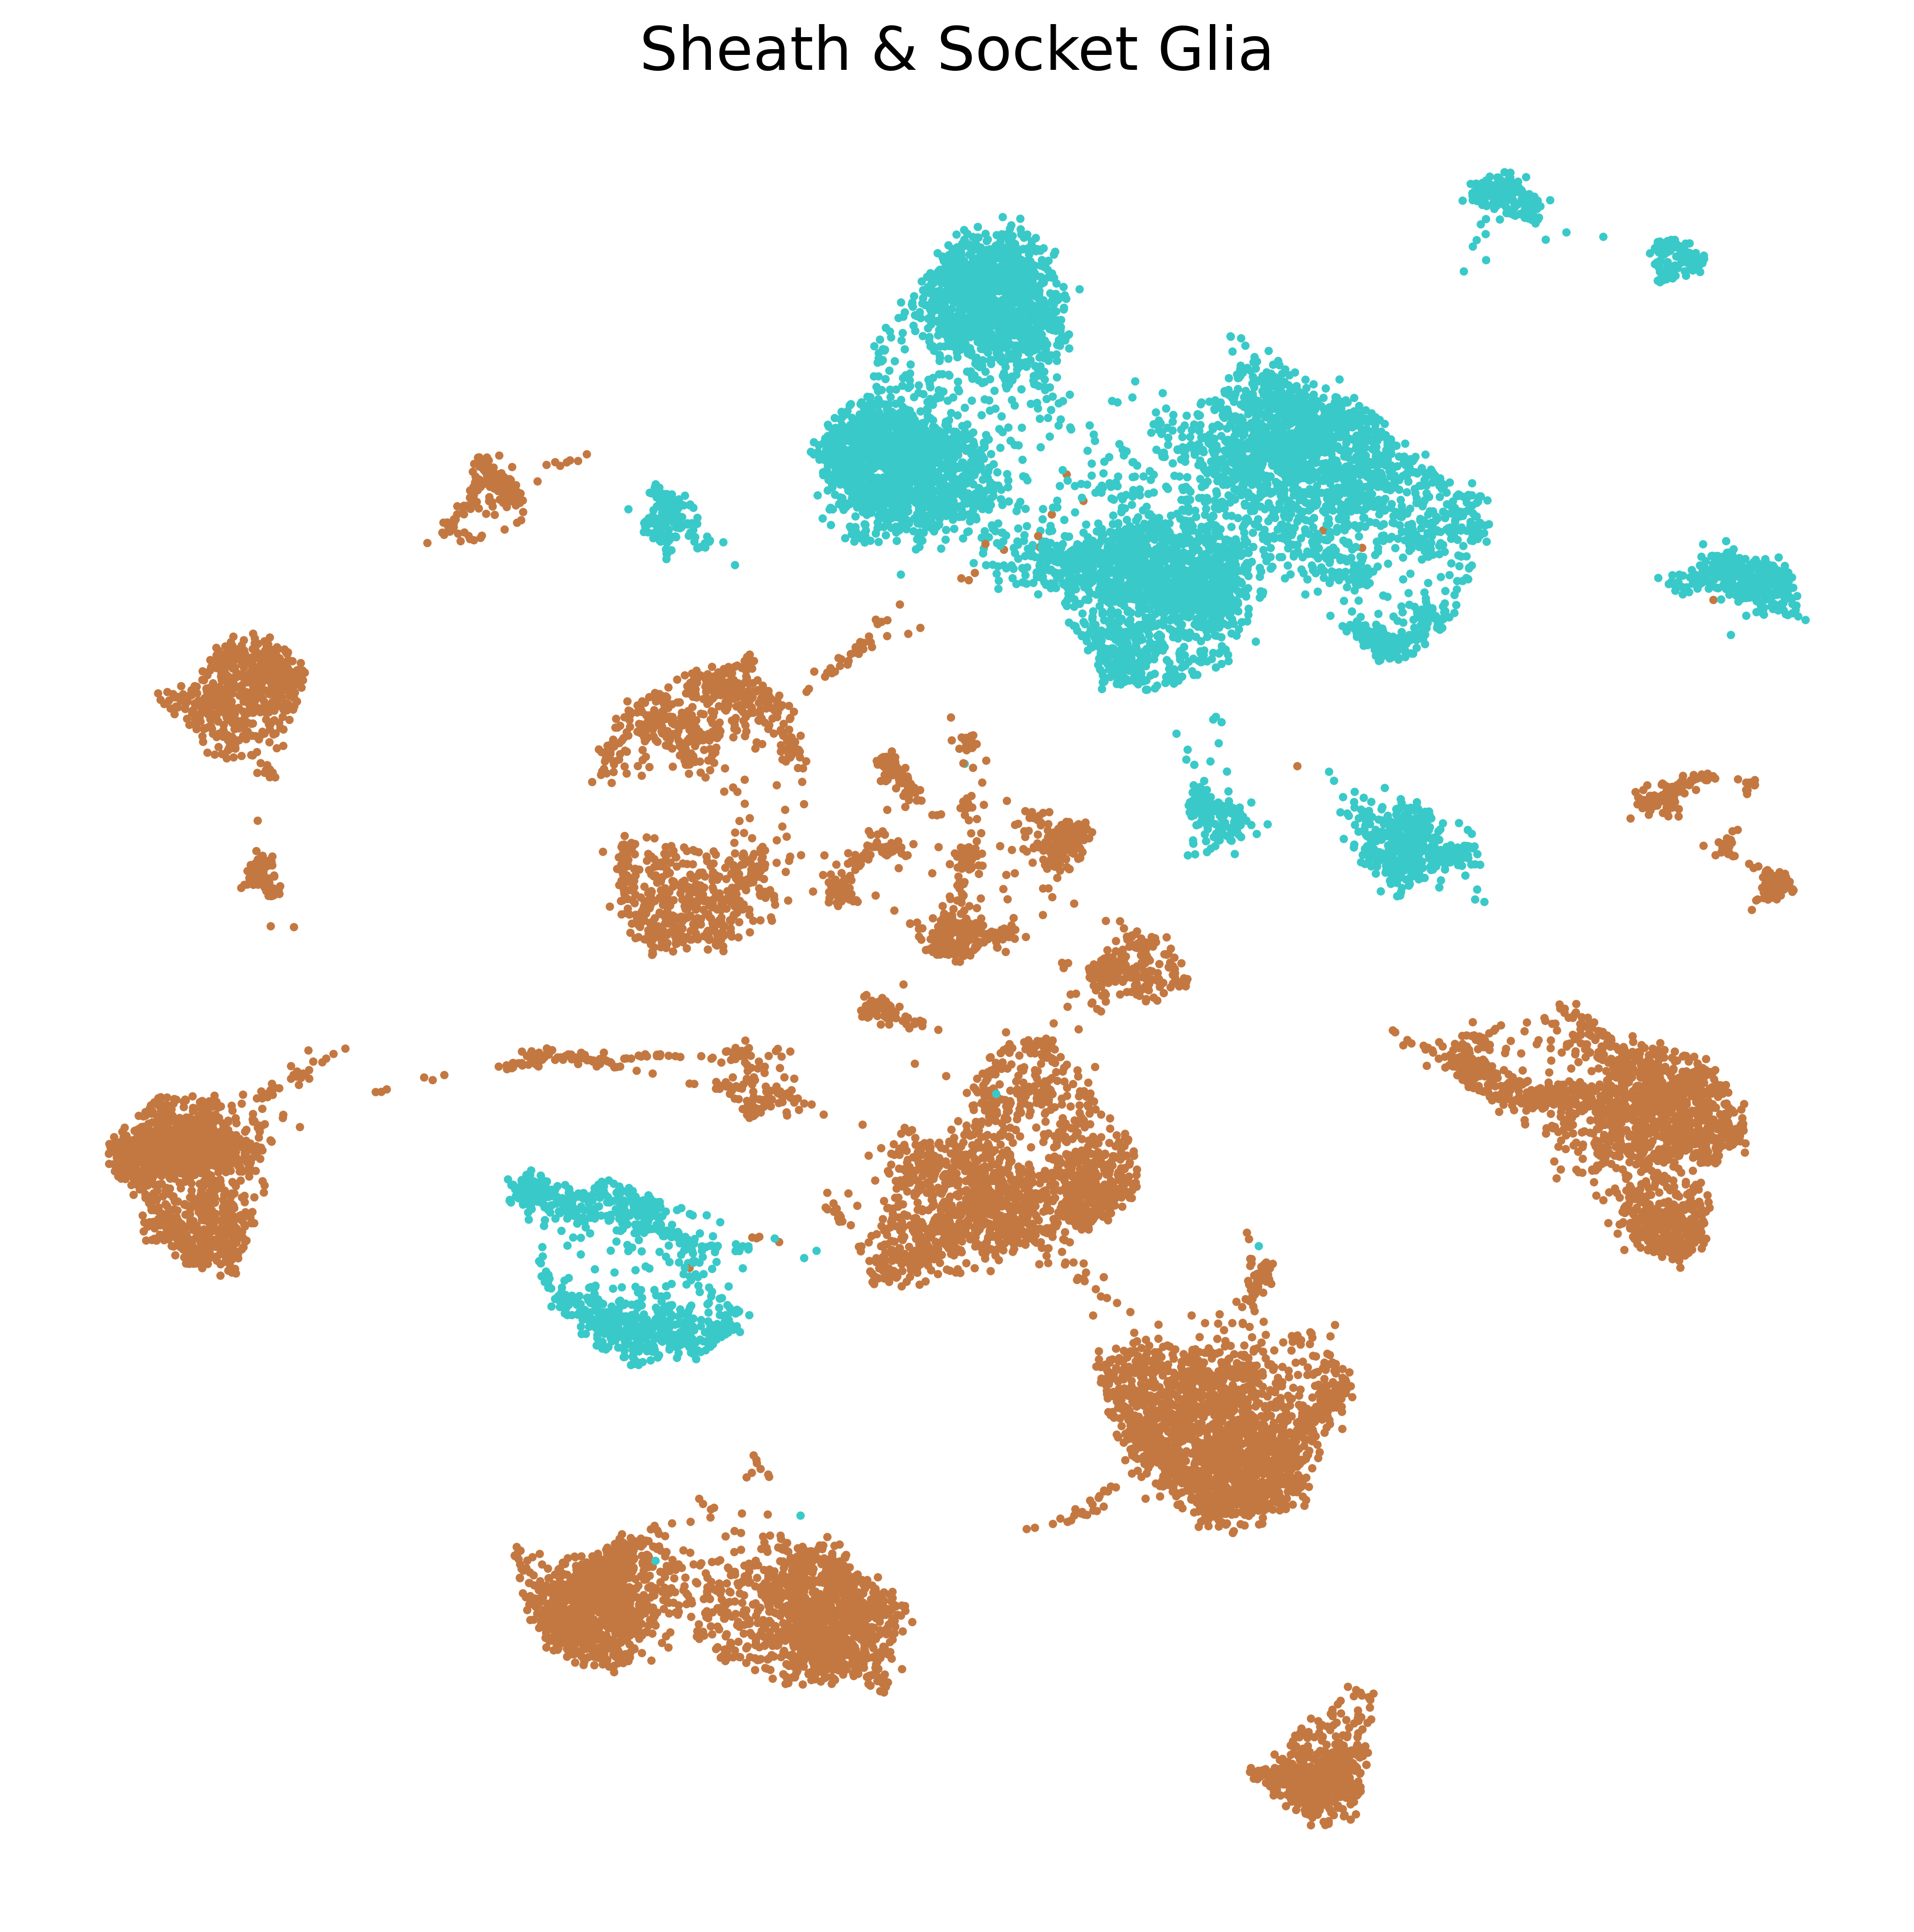

In [9]:
with matplotlib.pyplot.rc_context({'figure.figsize':UMAP_FIGSIZE,'font.size':15.0}):
    sc.pl.umap(
        adata_glia,
        color='SheathSocket_label',
        frameon=False,
        size=DOT_SIZE,
        legend_loc=None,
        title='Sheath & Socket Glia',
        save='figure_5B_SheathSocket_label.png'
    )

# Figure 5C -- Identified Sheath & Socket Glial Markers

In [10]:
# get the identified markers stored in the data
shso_marker = {
    'Socket': adata_glia.uns['FiguresData_Socket_Selection_Results']['Identified_Genes'],
    'Sheath': adata_glia.uns['FiguresData_Sheath_Selection_Results']['Identified_Genes']
}

In [11]:
# create the dendrogram and add to adata
adata_glia.uns['dendrogram_Cluster_Celltype'] = figure_utils.create_dendrogram(adata_glia.copy(), groupby='Cluster_Celltype', use_rep='X_pca_harmony')

categories: 0 - PHso2, 1 - ILsh, 2 - ADEso & PDEso, etc.
var_group_labels: Socket, Sheath


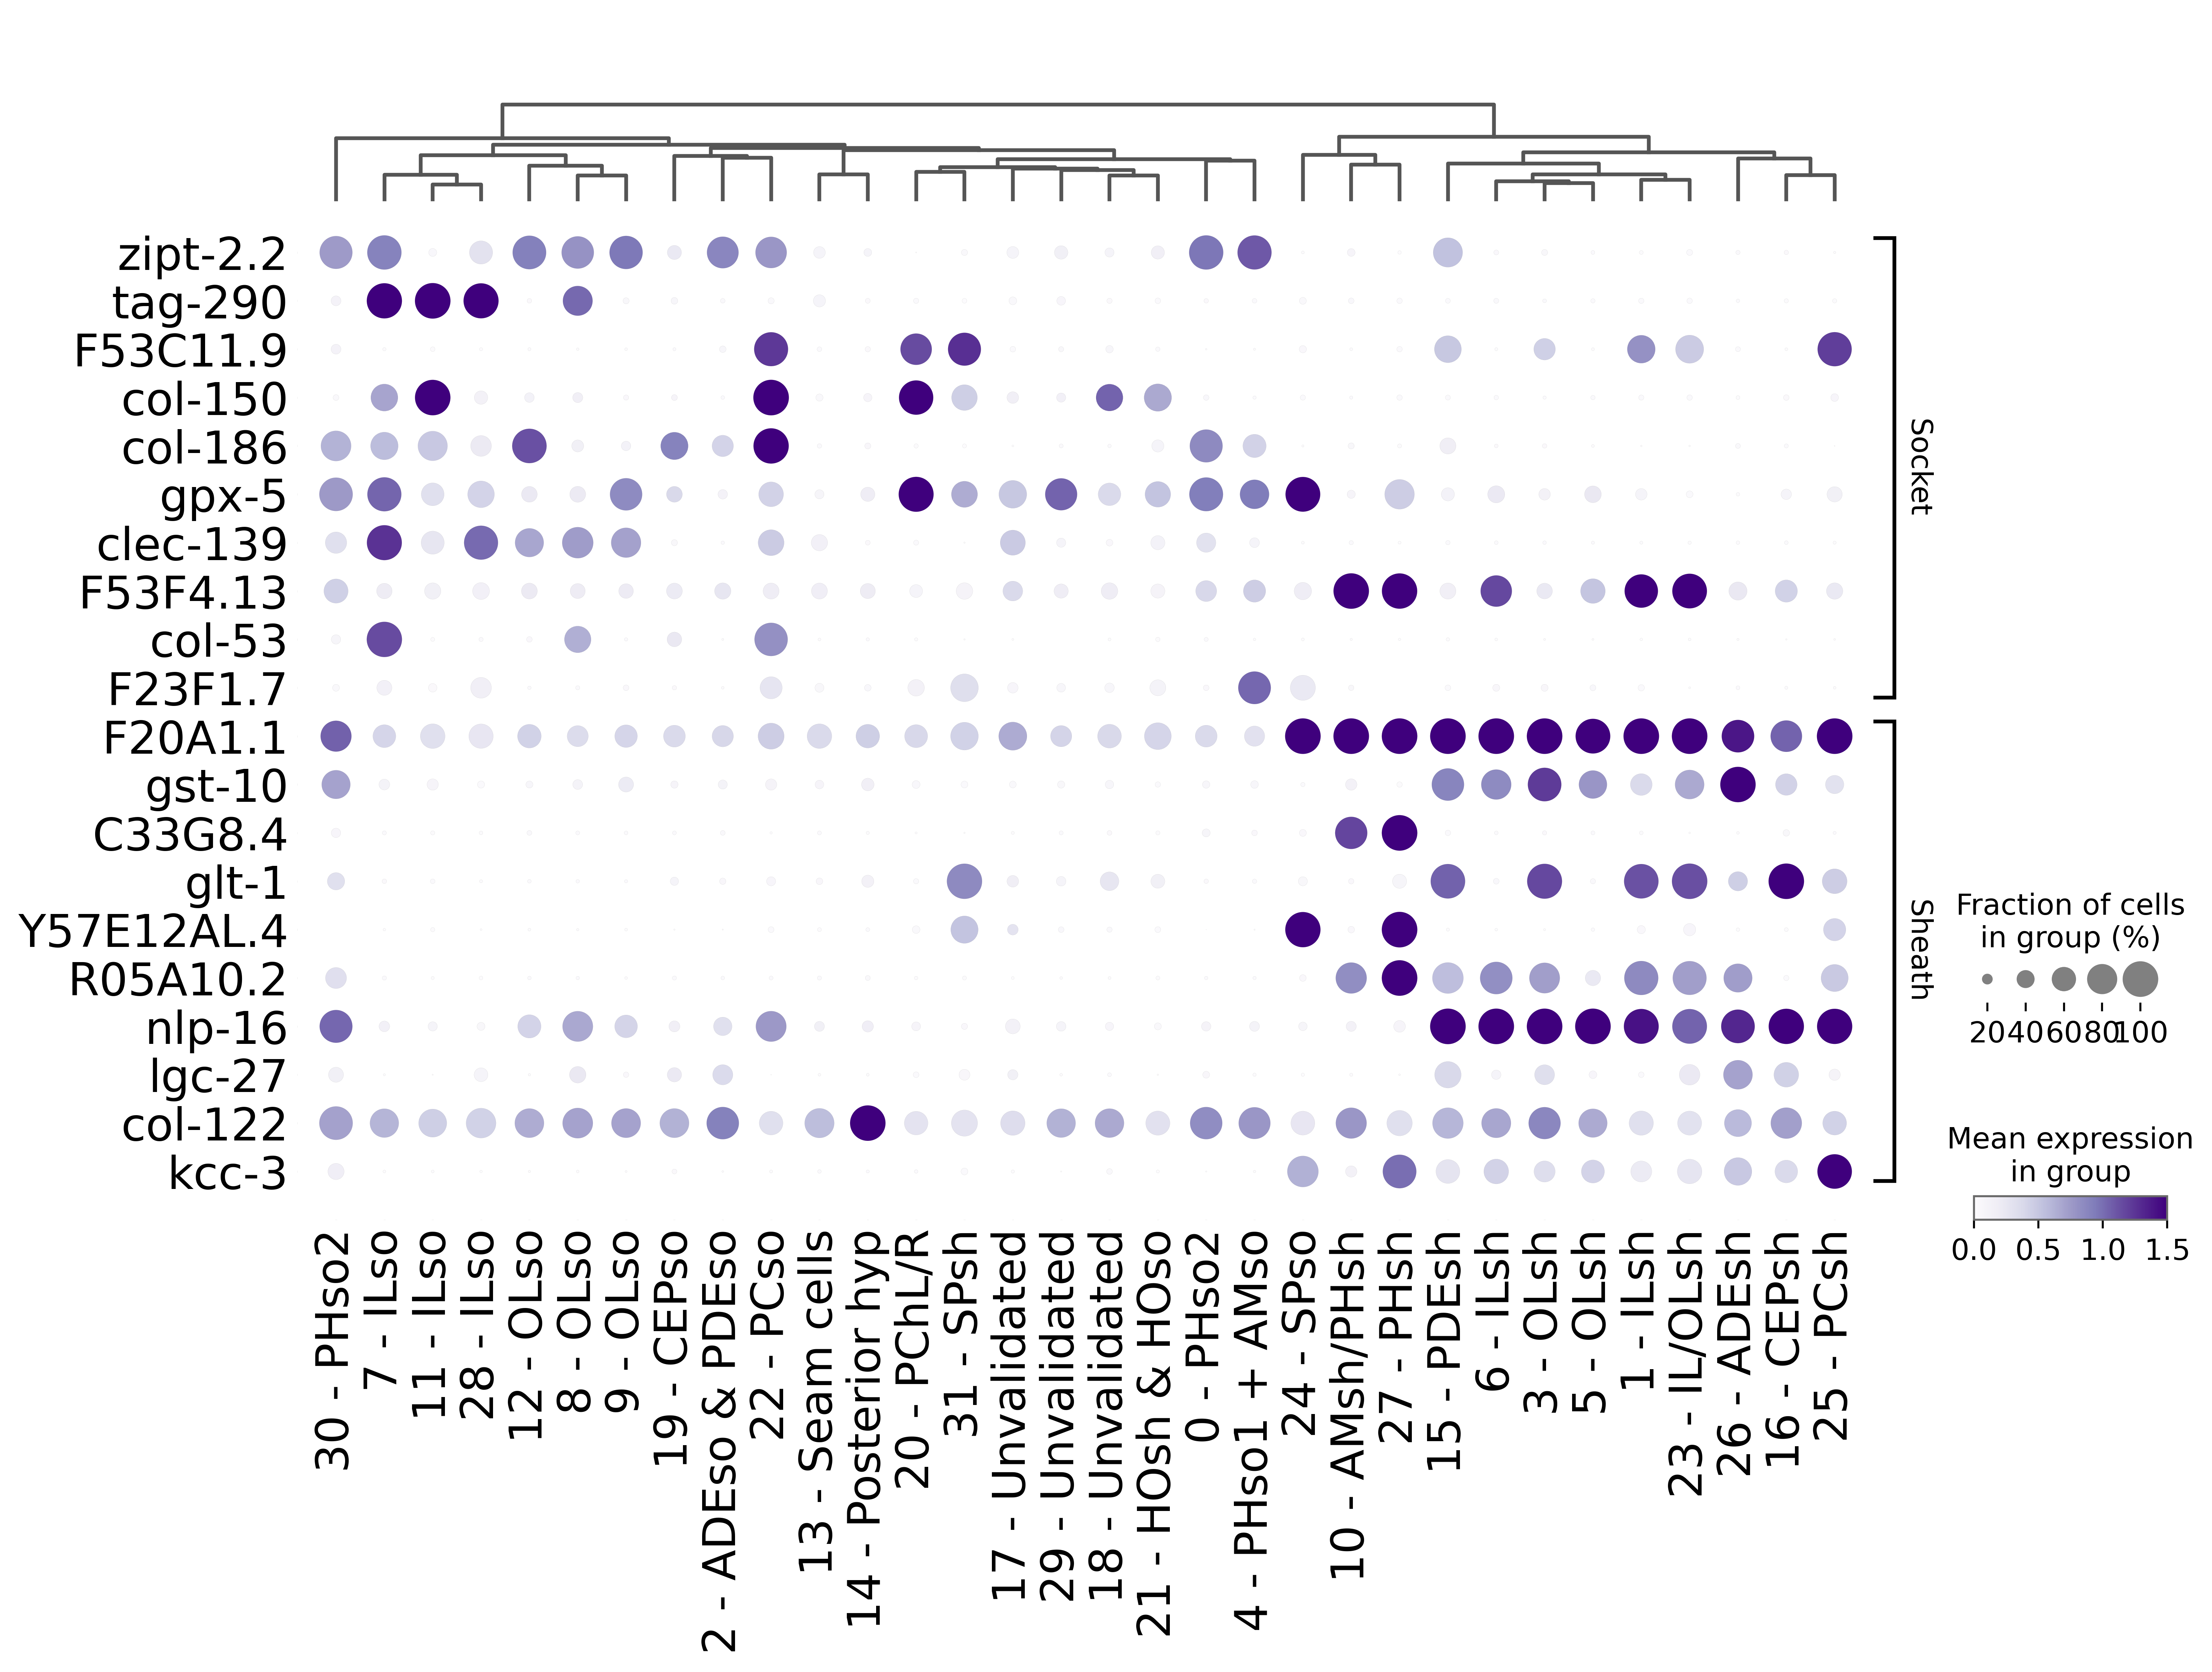

In [12]:
with matplotlib.pyplot.rc_context({'axes.edgecolor':'dimgray', 'xtick.color':AXIS_TICK_COLORS, 'ytick.color':AXIS_TICK_COLORS, 'figure.facecolor':'white','font.size':14}):
    dotplot = sc.pl.dotplot(adata_glia, var_names=shso_marker, groupby='Cluster_Celltype', cmap='Purples', 
                            return_fig=True, dendrogram=True, swap_axes=True,vmin=0, vmax=1.5)
    dotplot.dot_edge_lw = 0.01
    
    # fix aesthetics
    dotplot.get_axes()['mainplot_ax'].axes.tick_params(axis='both', which='both', length=0.01)
    
    # axis fonts/colors
    xticks = dotplot.get_axes()['mainplot_ax'].axes.get_xticklabels()
    yticks = dotplot.get_axes()['mainplot_ax'].axes.get_yticklabels()
    
    for tick in xticks:
        tick.set_fontsize(18)
        # tick.set_color
    
    for tick in yticks:
        tick.set_fontsize(18)
    
    # save
    plt.savefig('figures/figure_5C_SheathSocketMarkers_Dotplot.png', bbox_inches='tight', dpi=300)
    plt.savefig('figures/figure_5C_SheathSocketMarkers_Dotplot.svg', bbox_inches='tight', dpi=300)    

## Figure 5D -- Sheath/Socket, Minimal Optimal Set

In [13]:
matplotlib.rcParams['figure.dpi'] = 2000 # 150 dpi resolution
matplotlib.rcParams['image.cmap'] = 'Spectral_r' # preferred color map
# matplotlib.rcParams['figure.figsize'] = [6, 6] # Square
# no bounding boxes or axis:
matplotlib.rcParams['axes.spines.bottom'] = "off"
matplotlib.rcParams['axes.spines.top'] = "off"
matplotlib.rcParams['axes.spines.left'] = "off"
matplotlib.rcParams['axes.spines.right'] = "off"

%matplotlib inline

In [14]:
optimal_sets = {
    'Socket':adata_glia.uns['FiguresData_Socket_Selection_Results']['Sequential_Combo']['3_genes'],
    'Sheath':adata_glia.uns['FiguresData_Sheath_Selection_Results']['Sequential_Combo']['2_genes']
}

categories: 0 - PHso2, 1 - ILsh, 2 - ADEso & PDEso, etc.
var_group_labels: Socket, Sheath


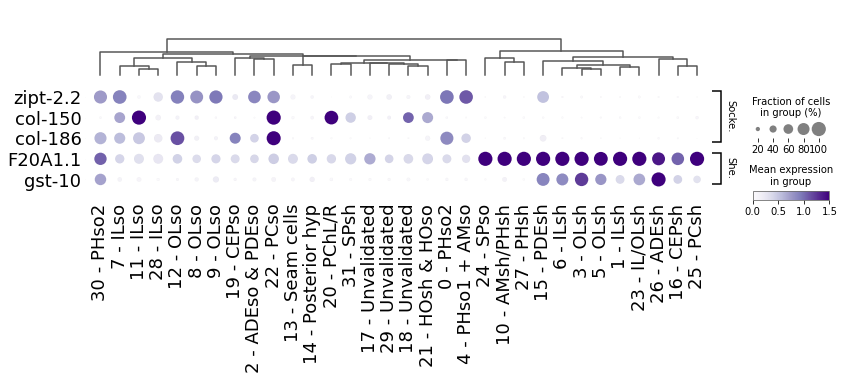

In [15]:
with matplotlib.pyplot.rc_context({'axes.edgecolor':'dimgray', 'xtick.color':AXIS_TICK_COLORS, 'ytick.color':AXIS_TICK_COLORS, 'figure.facecolor':'white','font.size':12}):
    dotplot = sc.pl.dotplot(adata_glia, var_names=optimal_sets, groupby='Cluster_Celltype', cmap='Purples', 
                            return_fig=True, dendrogram=True, swap_axes=True, vmin=0, vmax=1.5)
    dotplot.dot_edge_lw = 0.01
    
    # fix aesthetics
    dotplot.get_axes()['mainplot_ax'].axes.tick_params(axis='both', which='both', length=0.01)
    
    # axis fonts/colors
    xticks = dotplot.get_axes()['mainplot_ax'].axes.get_xticklabels()
    yticks = dotplot.get_axes()['mainplot_ax'].axes.get_yticklabels()
    
    for tick in xticks:
        tick.set_fontsize(18)
        # tick.set_color
    
    for tick in yticks:
        tick.set_fontsize(18)
    
    # save
    plt.savefig('figures/figure_5D_SheathSocket_SelectOptimalSet_Dotplot.png', bbox_inches='tight', dpi=300)